In [1]:
pip install imantics

  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16015 sha256=5fce8cb92323ccf6feade92fb3aaea35d904e2e8b24cc24eb5ec3aef5a6b030d
  Stored in directory: /root/.cache/pip/wheels/56/6a/be/4c60e88b14abec4e93234a1f7f91ce8abe1ae88a2b3eaad3ac
Successfully built imantics


In [2]:
pip install colorama

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import json
import os
import imantics
from PIL import Image
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
%matplotlib inline

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [4]:
base_dir = '/content/drive/MyDrive/buildings'
masks_dir = f'{base_dir}/train_masks/masks'
images_dir = f'{base_dir}/train_images/imgs'

In [5]:
image_size = 1920

In [6]:
images_listdir = os.listdir(images_dir)
print(f"{blk}Dataset contains {red}{len(images_listdir)} {blk}images")

Dataset contains 19 images


In [7]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

In [8]:
def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = mask > 0
    return mask

In [9]:
first9images = images_listdir[:9]

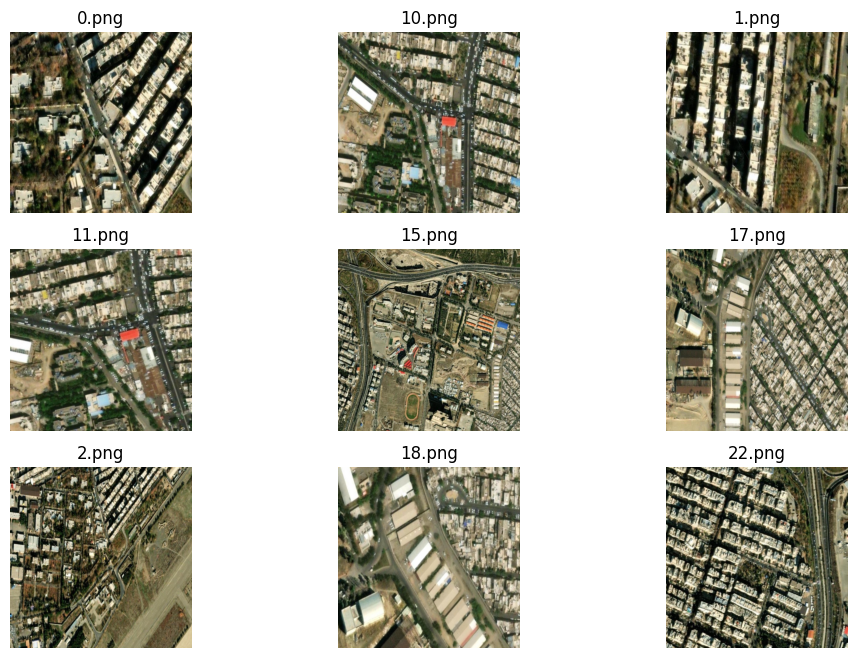

In [10]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (12,8))

for i, ax in enumerate(ax.flat):
    if i < len(first9images):
        img = read_image(f"{images_dir}/{first9images[i]}")
        ax.set_title(f"{first9images[i]}")
        ax.imshow(img)
        ax.axis('off')

In [11]:
masks_listdir = os.listdir(masks_dir)
print(f"{blk}Dataset contains {red}{len(masks_listdir)} {blk}masks")

Dataset contains 19 masks


In [12]:
first9masks = masks_listdir[:9]

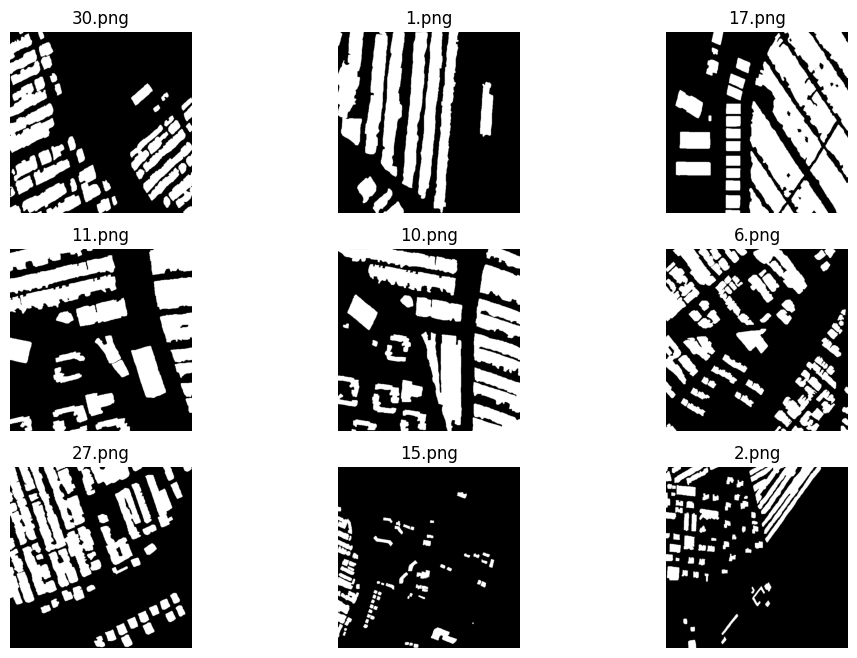

In [13]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (12,8))

for i, ax in enumerate(ax.flat):
    if i < len(first9masks):
        img = read_image(f"{masks_dir}/{first9masks[i]}")
        ax.set_title(f"{first9masks[i]}")
        ax.imshow(img)
        ax.axis('off')

In [14]:
images = np.zeros((len(images_listdir), image_size, image_size, 3), dtype=np.uint8)
masks = np.zeros((len(masks_listdir), image_size, image_size), dtype=bool)

for i in range(len(images_listdir)):
  cur_image = read_image(f"{images_dir}/{images_listdir[i]}")
  images[i] = cur_image

  cur_mask = read_mask(f"{masks_dir}/{images_listdir[i]}")
  masks[i] = cur_mask


In [15]:
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"{blk}== Training set shapes == \n{blk}Images : {red}{images_train.shape}\n{blk}Masks : {red}{masks_train.shape}")
print(f"{blk}== Test set shapes == \n{blk}Images : {red}{images_test.shape}\n{blk}Masks : {red}{masks_test.shape}")

== Training set shapes == 
Images : (15, 1920, 1920, 3)
Masks : (15, 1920, 1920)
== Test set shapes == 
Images : (4, 1920, 1920, 3)
Masks : (4, 1920, 1920)


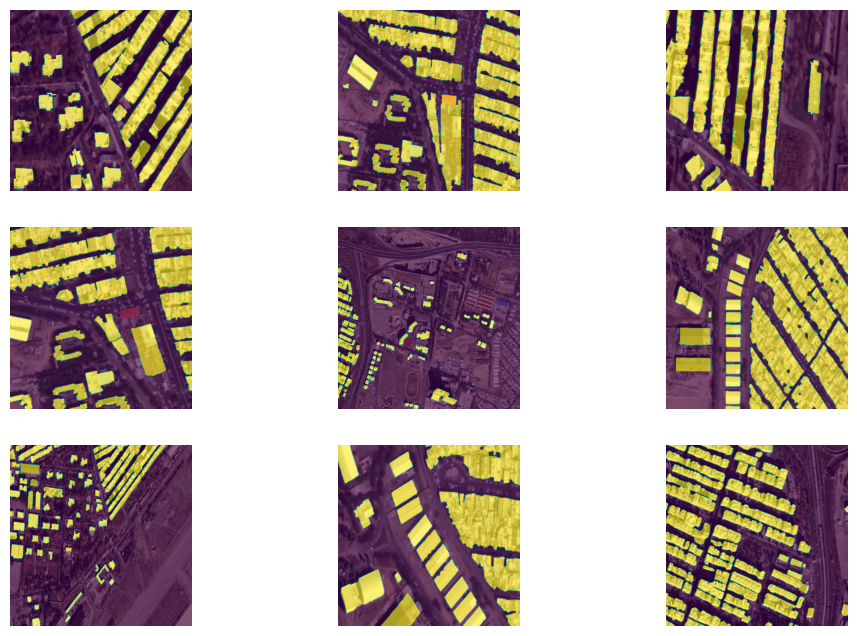

In [16]:
fig, ax = plt.subplots(rows, cols, figsize = (12,8))

for i, ax in enumerate(ax.flat):
    if i < 9:
        ax.imshow(images[i])
        ax.imshow(masks[i], alpha=0.6)
        ax.axis('off')

In [21]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [22]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((image_size, image_size, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920, 1920,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 1920, 1920,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 1920, 1920,   256        ['conv2d_19[0][0]']              
 ormalization)                  64)                                                           

In [23]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:
unet_result = unet_model.fit(images_train, masks_train, validation_split = 0.2, batch_size=1, epochs = 5)

Epoch 1/5
12/12 [==============================] - 1198s 2s/step - loss: 0.7817 - accuracy: 0.5419 - val_loss: 1.5592 - val_accuracy: 0.2367
Epoch 2/5
12/12 [==============================] - 22s 2s/step - loss: 0.7817 - accuracy: 0.5419 - val_loss: 1.1530 - val_accuracy: 0.3025
Epoch 3/5
12/12 [==============================] - 21s 2s/step - loss: 0.7817 - accuracy: 0.5419 - val_loss: 0.9715 - val_accuracy: 0.3675
Epoch 4/5
12/12 [==============================] - 21s 2s/step - loss: 0.7817 - accuracy: 0.5419 - val_loss: 0.8654 - val_accuracy: 0.4281
Epoch 5/5
12/12 [==============================] - 21s 2s/step - loss: 0.7817 - accuracy: 0.5419 - val_loss: 0.7964 - val_accuracy: 0.4826


In [25]:
unet_predict = unet_model.predict(images_test)
unet_predict = (unet_predict > 0.5).astype(np.uint8)

1/1 [==============================] - 67s 67s/step


In [26]:
def show_result(og, unet, target):
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net")
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

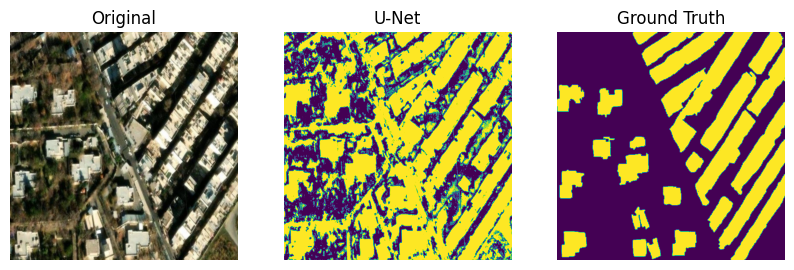

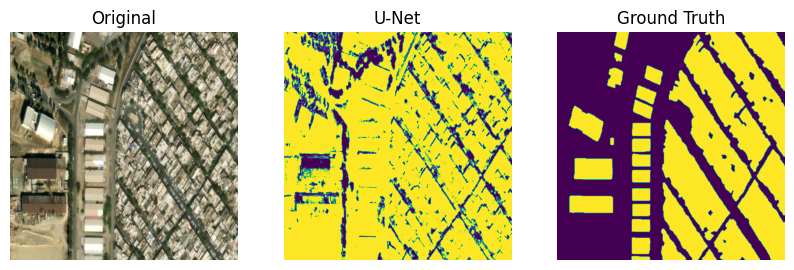

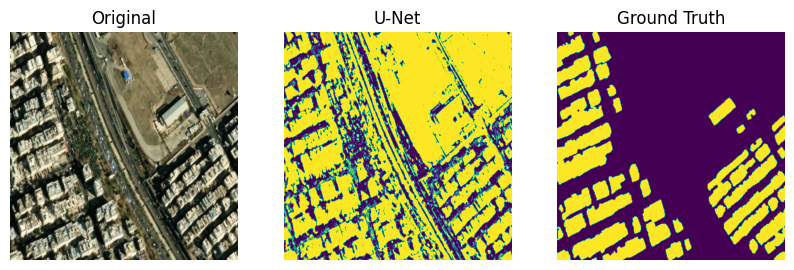

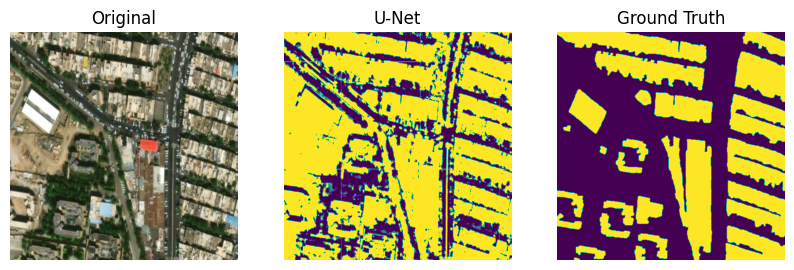

In [27]:
for i in range(4):
    show_result(images_test[i], unet_predict[i], masks_test[i])